# Convolutional Neural Network

This example shows how to design a simple quantization aware training CNN and how to measure 
the maximum accumulator bit width. We also show the impact of quantization on accuracy. 

To analyze the potential FHE-compatible quantization configurations, we use the simulation mode of
 the FHE circuit of the CNN. The maximum accumulator 
bit width that is currently allowed in Concrete ML is **16** bits, which limits the bit-widths 
that are usable for weights and activations.

We find an FHE compatible configuration for 3 bits weights and activations and run the CNN in FHE.
The accuracy in this highly quantized configuration is 92%. 

### Import required modules

In [1]:
import time
import torch.utils
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image

# And some helpers for visualization.
%matplotlib inline

from utils.dataset_utils import get_loaded_dataset, create_dataloader
from utils.cnn_utils import create_network, train_network, test_network
from utils.fhe_utils import compile_network, test_quantized_module, test_with_concrete
from utils.graphics_utils import plot_training_loss

from models.TinyCNN import TinyCNN
from models.HeavyCNN import HeavyCNN

### Load the data-set and visualize it

In [2]:
humans_path = './data/human-and-non-human/training_set/training_set/humans'
not_humans_path = './data/human-and-non-human/training_set/training_set/non-humans'
IMAGE_SIZE = 64
# image_dimensions = (IMAGE_SIZE, IMAGE_SIZE, 1) borrar no se usa
# transposed_image_dimensions = (1, IMAGE_SIZE, IMAGE_SIZE) borrar no se usa
x_train, x_test, y_train, y_test = get_loaded_dataset(
    humans_path,
    not_humans_path,
    IMAGE_SIZE
)

train_dataloader = create_dataloader(x_train, y_train, 64)
test_dataloader = create_dataloader(x_test, y_test, 1)

Humans files: 4011
Not humans files: 4006
./data/human-and-non-human/training_set/training_set/non-humans/airplane_0000.jpg
./data/human-and-non-human/training_set/training_set/non-humans/airplane_0001.jpg
./data/human-and-non-human/training_set/training_set/non-humans/airplane_0002.jpg
./data/human-and-non-human/training_set/training_set/non-humans/airplane_0003.jpg
./data/human-and-non-human/training_set/training_set/non-humans/airplane_0004.jpg
./data/human-and-non-human/training_set/training_set/non-humans/airplane_0005.jpg
./data/human-and-non-human/training_set/training_set/non-humans/airplane_0006.jpg
./data/human-and-non-human/training_set/training_set/non-humans/airplane_0007.jpg
./data/human-and-non-human/training_set/training_set/non-humans/airplane_0008.jpg
./data/human-and-non-human/training_set/training_set/non-humans/airplane_0009.jpg
./data/human-and-non-human/training_set/training_set/non-humans/airplane_0010.jpg
./data/human-and-non-human/training_set/training_set/non

### Define the neural network

Since the accumulator bit width in FHE is small, we prune the convolutional
filters to limit the number of connections per neuron.

Neural network **pruning** is the process by which the synapses of individual neurons in a layer
are forced to have a weight equal to zero. This basically eliminates them from the computation 
and thus they do not increase the accumulator bit width. It has been shown that neural networks can 
maintain their accuracy with a degree of pruning that can 
even exceed 70% for some over-parametrized networks such as VGG16 or large ResNets.

See: https://arxiv.org/pdf/2003.03033.pdf, Figure 8 in Section 7.2, for an evaluation on the 
simple pruning method used in this example.

In [3]:
n_classes = 2  # humans and not humans
n_bits = 6  # Quantization bit-width
p_error = 0.1  # Probability of error 

net = create_network(TinyCNN, n_classes)     

### Train the CNN

Note that the training code for quantization aware training is the same as it would be for
floating point training. Indeed, the Brevitas layers used in the CNN class will handle
quantization during training. 

We train the network for varying weights and activations bit-width, to find an FHE compatible 
configuration.

Training: 100%|██████████| 150/150 [00:09<00:00, 15.63it/s]


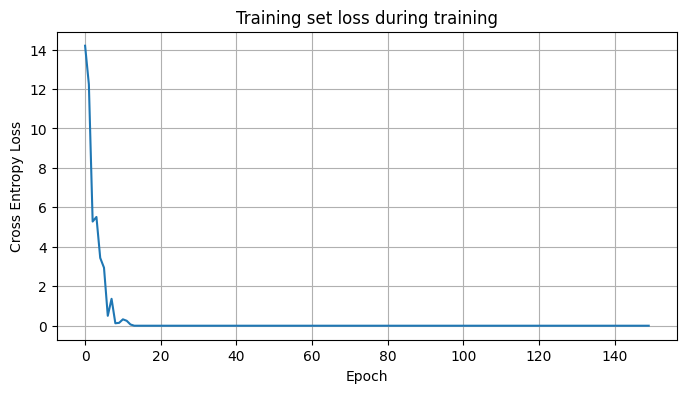

In [4]:
torch.manual_seed(42)

# Epochs to train for
N_EPOCHS = 150

# Train the network
losses = train_network(net, N_EPOCHS, train_dataloader)  

# Plot the cross-entropy loss for each epoch
plot_training_loss(losses)

### Test the torch network in fp32

In [5]:
# Test the network in fp32   
test_network(net, n_bits, test_dataloader)

Test accuracy for 6-bit weights and activations: 87.50%


### Define the Concrete ML testing function

We introduce the `test_with_concrete` function which allows us to test a Concrete ML model in one of two modes:
- in FHE
- in the clear, using simulated FHE execution

Note that it is trivial to toggle between between the two modes. 

### Test the network using Simulation

Note that this is not a test in FHE. The simulated FHE mode gives 
insight into the number of accumulator bits that are needed and the 
impact of FHE execution on the accuracy.

The torch/brevitas neural network is quantized during training and, for inference, it is converted 
to FHE by Concrete ML using a dedicated function, `compile_brevitas_qat_model`.

In this test we determine the accuracy and accumulator bit-widths for the various quantization settings
that are trained above.

In [6]:
q_module_fhe = compile_network(net, x_train, n_bits, p_error)

# Test the network in FHE using simulation
test_quantized_module(q_module_fhe, n_bits, test_dataloader, use_sim=True)

100%|██████████| 40/40 [00:00<00:00, 652.00it/s]

Simulated FHE execution for 6 bit network accuracy: 87.50%


### 2. Generate Keys

In [7]:
# Generate keys first, this may take some time (up to 30min)
t = time.time()
q_module_fhe.fhe_circuit.keygen()
print(f"Keygen time: {time.time()-t:.2f}s")

Keygen time: 6.69s


### 3. Execute in FHE on encrypted data

In [8]:
def save_image(image_data, filename):
    # print(image_data.shape)
    # Create an Image object from the NumPy array
    image = Image.fromarray(image_data.squeeze().astype("uint8"), mode='L')
    # print(image.size)
    # Save the image to a file
    image.save(filename)  # Change 'saved_image.jpg' to your desired file name and format

def transpose_data_for_image(data):
    # Transpose the data to match the image format
    data = data.transpose(1, 2, 0)
    # Convert the data to uint8
    data = data.astype("uint8")
    # print(data.shape)
    return data

In [9]:
# Run inference in FHE on a single encrypted example
index = 20
mini_test_dataset = TensorDataset(torch.Tensor(x_test[[index], :]), torch.Tensor(y_test[[index]]))
mini_test_dataloader = DataLoader(mini_test_dataset)
# Save x_text[0] as an image
print(x_test[0].shape)
print(int(y_test[index]))
save_image(transpose_data_for_image(x_test[index]), "saved_image.jpg")
print(len(x_test))

(1, 64, 64)
1
40


In [10]:


# import numpy as np
# 
# path = "./data/abdul/abdul-karim.256x256.jpg"
# # #Open image
# img = Image.open(path).resize(image_dimensions[:2]).convert('L')
# img_array = np.array(img)
# 
# test_set = np.zeros((1, *transposed_image_dimensions), dtype='float32')
# test_set[0] = img_array
# print(test_set[[0]].shape)
# 
# save_image(transpose_data_for_image(test_set[0]), "saved_image.jpg")
# 
# mini_test_dataset = TensorDataset(torch.Tensor(test_set[[0]]), torch.Tensor([[1]]))
# mini_test_dataloader = DataLoader(mini_test_dataset)

In [11]:
t = time.time()
res = test_with_concrete(
    q_module_fhe,
    mini_test_dataloader,
    use_sim=False,
)
print(f"Time per inference in FHE: {(time.time() - t) / len(mini_test_dataset):.2f}")
print(f"Accuracy in FHE: {res:.2f}%")

100%|██████████| 1/1 [02:22<00:00, 142.83s/it]

Time per inference in FHE: 142.84
Accuracy in FHE: 100.00%


### Conclusion

We see that quantization with **3** bit weight and activations is the best viable FHE configuration,
as the accumulator bit width for this configuration is between **7 and 8** bits (can vary due to the final 
distribution of the weights). The accuracy in this setting, 92% is a few percentage points 
under the maximum accuracy achievable with larger accumulator bit widths (97-98%). 

Compiling the higher bit-width networks is also possible, but in this example, to ensure FHE execution is fast
we used the lower bit-width quantization setting.
